In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from numpy.linalg import inv
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Generate N = 10000 random numbers from [0, 1]:
x1, x2, . . . , xN ∈ [0, 1] ,
and then obtain their labels: yi =
√
1 + xi
, i = 1, 2, . . . , N.



In [ ]:
N = 1000

X = np.random.uniform(0, 1, N)
y = np.sqrt(1 + X)

In [ ]:
X.shape, y.shape

((1000,), (1000,))

Train Test Val split Data

In [ ]:
def train_test_val_split(X, Y, test_size=0.2, val_size=0.2):
  X_temp, X_test, y_temp, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)

  val_size = val_size / (1 - test_size)

  X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_size, random_state=42)

  return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_split(X, y)

In [ ]:
X_train.shape, X_test.shape, X_val.shape

((600,), (200,), (200,))

In [ ]:
# add 1s for bias
X_train = np.c_[np.ones(X_train.shape[0]), X_train]
X_val = np.c_[np.ones(X_val.shape[0]), X_val]
X_test = np.c_[np.ones(X_test.shape[0]), X_test]

In [ ]:
X_train.shape, X_test.shape, X_val.shape

((600, 2), (200, 2), (200, 2))

Linear Regression Closed Form Solution

In [ ]:
weights = inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)

In [ ]:
weights

array([1.01341295, 0.41205347])

In [ ]:
y_pred_val = X_val.dot(weights)
print("Validation MSE: ", mean_squared_error(y_val, y_pred_val))

Validation MSE:  2.5772586954229273e-05


In [ ]:
y_pred = X_test.dot(weights)
print("Test MSE: ", mean_squared_error(y_test, y_pred))

Test MSE:  2.9189201114517663e-05


Linear Regression using sklearn

In [ ]:
model = LinearRegression().fit(X_train, y_train)

In [ ]:
model.intercept_

1.013412952854936

In [ ]:
model.coef_

array([0.        , 0.41205347])

In [ ]:
model.coef_[0] = model.intercept_

In [ ]:
y_pred_val = model.predict(X_val)
print("Validation MSE: ", mean_squared_error(y_val, y_pred_val))

Validation MSE:  1.027082329779287


In [ ]:
y_pred_test = model.predict(X_test)
print("Test MSE: ", mean_squared_error(y_test, y_pred_test))

Test MSE:  1.0290111248847398


Linear Regression with Gradient Descent

In [ ]:
class LinearRegressionGD:
  def __init__(self, max_iter=1000, lr=0.01, metric_change=0.0001):
    self.max_iter = max_iter
    self.lr = lr
    self.metric_change = metric_change

  def update_weights(self, x, y):
    n = x.shape[0]
    y_pred = self.predict(x)
    d_w0 = -2/n * np.sum(y - y_pred)
    d_w1 = -2/n * np.sum(x[:, 1:] * (y - y_pred).reshape(-1, 1))
    gradient = np.array([d_w0, d_w1])
    self.weights -= self.lr * gradient

  def score(self, x, y):
    y_pred = self.predict(x)
    return np.mean((y - y_pred)**2)

  def fit(self, x_train, y_train, x_val, y_val):
    self.weights = np.zeros(x_train.shape[1])
    prev_score = float('-inf')

    for i in range(self.max_iter):
      self.update_weights(x_train, y_train)
      val_score = self.score(X_val, y_val)
      if abs(val_score - prev_score) < self.metric_change:
        break
      prev_score = val_score
    return self


  def predict(self, x):
    return x.dot(self.weights)

In [ ]:
model_gd = LinearRegressionGD().fit(X_train, y_train, X_val, y_val)

In [ ]:
model_gd.weights

array([0.93531769, 0.47827034])

In [ ]:
y_pred_test = model_gd.predict(X_test)
print("Test MSE: ", mean_squared_error(y_test, y_pred_test))

Test MSE:  0.0022676401315474483


Linear Regression with Stochastic Gradient Descent

In [ ]:
class LinearRegressionSGD:
  def __init__(self, max_iter=1000, lr=0.001, metric_change=0.0001):
    self.max_iter = max_iter
    self.lr = lr
    self.metric_change = metric_change

  def update_weights(self, x, y):
    y_pred = self.predict(x)
    d_w0 = -2* (y - y_pred)
    d_w1 = -2* (x[1] * (y - y_pred))
    gradient = np.array([d_w0, d_w1])
    self.weights -= self.lr * gradient

  def score(self, x, y):
    y_pred = self.predict(x)
    return np.mean((y - y_pred)**2)

  def fit(self, x_train, y_train, x_val, y_val):
    self.weights = np.zeros(x_train.shape[1])
    prev_score = float('-inf')

    for i in range(self.max_iter):
      random_index = np.random.randint(0, len(x_train))
      self.update_weights(x_train[random_index], y_train[random_index])
      val_score = self.score(X_val, y_val)
      if abs(val_score - prev_score) < self.metric_change:
        break
      prev_score = val_score
    return self


  def predict(self, x):
    return x.dot(self.weights)

In [ ]:
model_sgd = LinearRegressionSGD().fit(X_train, y_train, X_val, y_val)

In [ ]:
model_sgd.weights

array([0.84782832, 0.44534599])

In [ ]:
y_pred_test = model_sgd.predict(X_test)
print("Test MSE: ", mean_squared_error(y_test, y_pred_test))

Test MSE:  0.021858913304025025


Linear Regression with Mini-batch Gradient Descent

In [ ]:
class LinearRegressionBGD:
  def __init__(self, max_iter=1000, lr=0.001, metric_change=0.0001, batch_size=100):
    self.max_iter = max_iter
    self.lr = lr
    self.metric_change = metric_change
    self.batch_size = batch_size

  def update_weights(self, x, y):
    n = x.shape[0]
    y_pred = self.predict(x)
    d_w0 = -2/n* np.sum(y - y_pred)
    d_w1 = -2/n* np.sum(x[:,1:] * (y - y_pred))
    gradient = np.array([d_w0, d_w1])
    self.weights -= self.lr * gradient

  def score(self, x, y):
    y_pred = self.predict(x)
    return np.mean((y - y_pred)**2)

  def fit(self, x_train, y_train, x_val, y_val):
    self.weights = np.zeros(x_train.shape[1])
    prev_score = float('-inf')

    for i in range(self.max_iter):
      indices = np.random.choice(x_train.shape[0], self.batch_size, replace=False)
      self.update_weights(x_train[indices], y_train[indices])
      val_score = self.score(X_val, y_val)
      if abs(val_score - prev_score) < self.metric_change:
        break
      prev_score = val_score
    return self


  def predict(self, x):
    return x.dot(self.weights)

In [ ]:
model_bgd = LinearRegressionBGD().fit(X_train, y_train, X_val, y_val)

In [ ]:
model_bgd.weights

array([0.04546267, 2.2625328 ])

In [ ]:
y_pred_test = model_bgd.predict(X_test)
print("Test MSE: ", mean_squared_error(y_test, y_pred_test))

Test MSE:  0.3074881710606223


Sketch the graphs of all approximations on one graph.

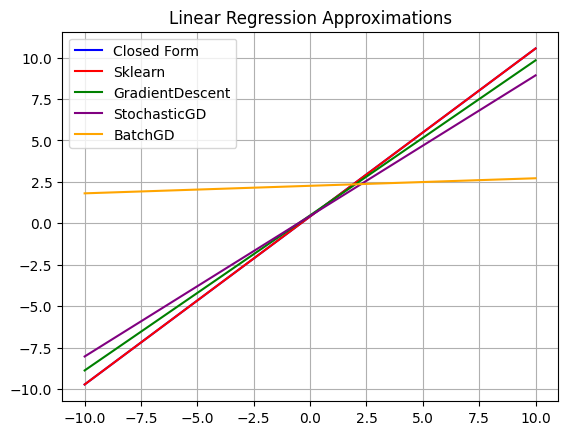

In [ ]:
import matplotlib.pyplot as plt

closed_form_weights = weights
sklearn_weights = model.coef_
gd_weights = model_gd.weights
sgd_weights = model_sgd.weights
bgd_weights = model_bgd.weights


x = np.linspace(-10, 10, 400)

plt.plot(x, closed_form_weights[0]*x + closed_form_weights[1], label='Closed Form', color='blue')
plt.plot(x, sklearn_weights[0]*x + sklearn_weights[1], label='Sklearn', color='red')
plt.plot(x, gd_weights[0]*x + gd_weights[1], label='GradientDescent', color='green')
plt.plot(x, sgd_weights[0]*x + sgd_weights[1], label='StochasticGD', color='purple')
plt.plot(x, bgd_weights[0]*x + bgd_weights[1], label='BatchGD', color='orange')


plt.legend()
plt.title('Linear Regression Approximations')
plt.grid(True)
plt.show()

Compare all solutions with the first degree Taylor approximation of
the function √
1 + x.

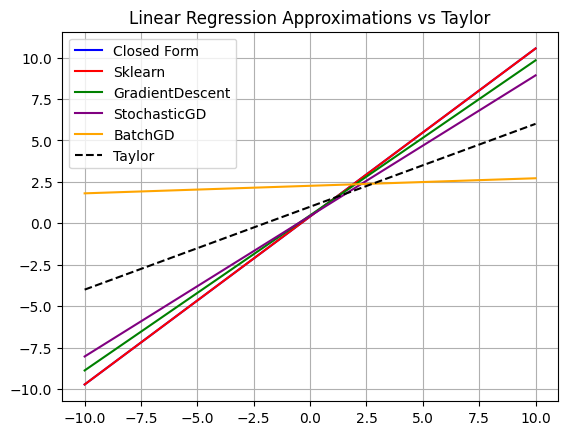

In [ ]:
taylor = 1 + 0.5 * x

x = np.linspace(-10, 10, 400)

plt.plot(x, closed_form_weights[0]*x + closed_form_weights[1], label='Closed Form', color='blue')
plt.plot(x, sklearn_weights[0]*x + sklearn_weights[1], label='Sklearn', color='red')
plt.plot(x, gd_weights[0]*x + gd_weights[1], label='GradientDescent', color='green')
plt.plot(x, sgd_weights[0]*x + sgd_weights[1], label='StochasticGD', color='purple')
plt.plot(x, bgd_weights[0]*x + bgd_weights[1], label='BatchGD', color='orange')
plt.plot(x, taylor, label='Taylor', color='black', linestyle='--')


plt.legend()
plt.title('Linear Regression Approximations vs Taylor')
plt.grid(True)
plt.show()